# Installing Packages and Dependencies

In [1]:
!pip install tensorflow-text==2.4.2
!pip install tf-models-official==2.4
!pip install tensorflow-gpu==2.4.2
!pip install delayed
!pip install alt-profanity-check
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
import joblib
from profanity_check import predict, predict_prob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

     |████████████████████████████████| 3.4 MB 603 kB/s            
     |████████████████████████████████| 394.5 MB 35 kB/s              
     |████████████████████████████████| 462 kB 42.3 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 3.8 MB 48.6 MB/s            
     |████████████████████████████████| 2.9 MB 41.3 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77051 sha256=ae690726593ca3bc235cbf5f675245074149ddd12541c82db23cabe0b08df601
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Succe

2022-03-20 18:24:26.455395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to un

In [2]:
print(tf.__version__)

2.4.2


In [3]:
# os.environ(TF_CPP_MIN_LOG_LEVEL=2)

In [4]:
!nvidia-smi 

Sun Mar 20 18:24:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
tf.test.is_gpu_available()

2022-03-20 18:24:36.207185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-20 18:24:36.207692: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


True

2022-03-20 18:24:36.209620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-20 18:24:36.246047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 18:24:36.246783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-03-20 18:24:36.246917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-20 18:24:36.247018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-20 18:24:36.247058: I tensorflow/stream_executor/plat

# Reading Training Data

In [6]:
df_train = pd.read_csv("../input/covid-misinfo/Constraint_English_Train.csv")
df_val = pd.read_csv("../input/covid-misinfo/Constraint_English_Val.csv")
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df = pd.concat([df_train, df_val, df_test], ignore_index=True)
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [7]:
df.shape

(10700, 3)

# Training Data Insight

In [8]:
df.groupby('label').describe()

id                                                                
        count         mean          std  min     25%     50%      75%     max
label                                                                        
fake   5100.0  2373.648627  1821.186440  1.0  902.00  1812.0  3761.50  6419.0
real   5600.0  2337.061071  1819.161764  1.0  884.75  1757.0  3726.75  6420.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


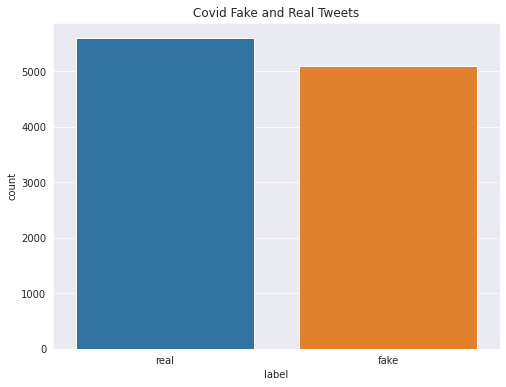

In [9]:
plt.figure(figsize=(8,6))
sns.set_style(style='darkgrid')
sns.countplot(df['label'])
plt.title("Covid Fake and Real Tweets")
plt.show()

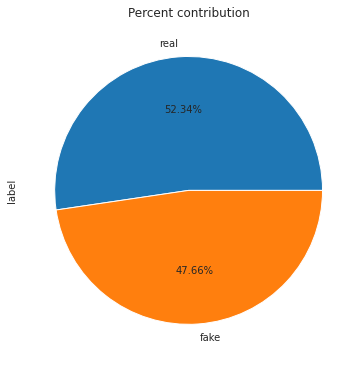

In [10]:
plt.figure(figsize=(6,8))
sns.set_style("darkgrid")
df["label"].value_counts().plot.pie(autopct='%0.2f%%')
plt.title("Percent contribution")
plt.show()

# Data Cleaning

In [11]:
#Data Cleaning
ps = PorterStemmer()
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
en_stopwords = set(stopwords.words("english"))

In [13]:
def cleaner(text):
    try:
        url_re = re.compile(r'(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?')
        cleaned = url_re.sub("",text)
        
        hashtag_re = re.compile(r'(#\w+)')
        cleaned = hashtag_re.sub("",cleaned)
        
        screen_name_re = re.compile(r'(@\w+)')
        cleaned = screen_name_re.sub("", cleaned)
        
        emoji_re = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U0001F1F2-\U0001F1F4"  # Macau flag
                u"\U0001F1E6-\U0001F1FF"  # flags
                u"\U0001F600-\U0001F64F"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U0001F1F2"
                u"\U0001F1F4"
                u"\U0001F620"
                u"\u200d"
                u"\u2640-\u2642"
                "]+", flags=re.UNICODE)
        cleaned = emoji_re.sub("",cleaned)
        
        cleaned = cleaned.replace("."," ").replace("//"," ")
        cleaned = re.sub(r'[^a-zA-Z]', " ", cleaned) #Replacing all non-alphabets with " "
        cleaned = re.sub(r'\w+\d+', " ", cleaned) #Removes alphanumeric words

        cleaned = ps.stem(cleaned)

        cleaned = " ".join([word for word in cleaned.split() if len(word)>2]) #Removing words with len<2
        cleaned = " ".join([word for word in cleaned.split() if word not in en_stopwords])

        cleaned = cleaned.strip() #Removing whitespaces
        cleaned = cleaned.lower() #Converting to lower case

    except:
        cleaned = ""
    return cleaned
    
df['tweet'] = df['tweet'].apply(lambda text: cleaner(text))
df.head()

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real


# Generating Word Clouds

In [14]:
df

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,testing laboratories india august tests done,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
10695,2136,state wise details total confirmed cases till ...,real
10696,2137,tonight midnight onwards disaster management a...,fake
10697,2138,new cases plateau enugu oyo lagos rivers fct k...,real
10698,2139,one stop shop resources section communicating ...,real


In [15]:
#Function to get word frequencies in the data
def get_word_freqs(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

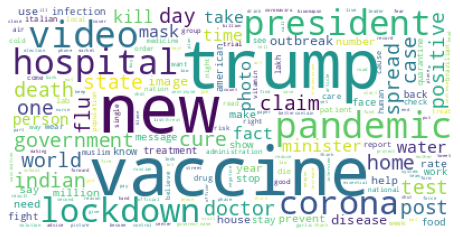

In [16]:
freq_words_fake = get_word_freqs(df[df['label']=='fake'],'tweet')
freq_words_fake = " ".join(freq_words_fake.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_fake)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

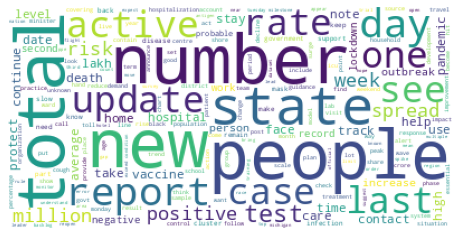

In [17]:
freq_words_real = get_word_freqs(df[df['label']=='real'],'tweet')
freq_words_real = " ".join(freq_words_real.index)
word_cloud=WordCloud(max_font_size=60,background_color='white').generate(freq_words_real)
plt.figure(figsize=(8,6))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [18]:
#splitting the labels
df_real = df[df['label']=='real']
df_real.shape

(5600, 3)

In [19]:
df_fake = df[df['label']=='fake']
df_fake.shape

(5100, 3)

# Downsampling Data

In [20]:
#unbalanced data so we downsample it
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(5100, 3)

In [21]:
df_balanced = pd.concat([df_fake, df_real_downsampled])
df_balanced['label'].value_counts()

fake    5100
real    5100
Name: label, dtype: int64

In [22]:
df_balanced['fake'] = df_balanced['label'].apply(lambda x: 1 if x == 'fake' else 0)
df_balanced.sample(5)

,id,tweet,label,fake
310,311,new covid net data reported hospitalizations a...,real,0
1068,1069,moved green covid warning dashboard indicating...,real,0
1600,1601,whatsapp message says taht ecuador cure corona...,fake,1
7581,1162,new york state hospitals reporting thousands f...,fake,1
2235,2236,states reported almost new cases day average r...,real,0


In [23]:
df_test = pd.read_csv("../input/covid-misinfo/Constraint_English_Test.csv")
df_test['tweet'] = df_test['tweet'].apply(lambda text: cleaner(text))
df_test['fake'] = df_test['label'].apply(lambda x: 1 if x == 'fake' else 0)
y_test = df_test[['fake']]

# Model Construction

In [24]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
    
    return np.array(all_tokens)

In [25]:
def build_model(transformer, max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
    
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    
    return model

In [26]:
%%time
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-03-20 18:25:18.804904: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-20 18:25:18.805340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 18:25:18.805962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-03-20 18:25:18.806056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-20 18:25:18.806116: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-20 18:25:18.806140: I tensorflow/stream_executor/platform/

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

CPU times: user 8.54 s, sys: 1.77 s, total: 10.3 s
Wall time: 20.9 s


In [27]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model = build_model(transformer_layer, max_len=160)
model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None,)]                 0         
_________________________________________________________________
tf_distil_bert_model (TFDist TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [28]:
train_input = bert_encode(df_balanced.tweet.values, tokenizer, max_len=160)
test_input = bert_encode(df_test.tweet.values, tokenizer, max_len=160)
train_labels = df_balanced.fake.values

In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                              mode='min',
                              verbose=1,
                              patience=3,
                              min_delta=0.0001,
                              factor=0.2
                             )
]

# Training the Model

In [30]:
train_history = model.fit(
    train_input, train_labels,
    epochs=12,
    batch_size=1,
    callbacks = callbacks, verbose=1
)

2022-03-20 18:25:43.824084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-20 18:25:43.825010: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/12
10200/10200 [==============================] - 274s 26ms/step - loss: 0.3366 - accuracy: 0.8429 - precision: 0.8374 - recall: 0.8576
Epoch 2/12
10200/10200 [==============================] - 266s 26ms/step - loss: 0.1144 - accuracy: 0.9569 - precision: 0.9517 - recall: 0.9629
Epoch 3/12
10200/10200 [==============================] - 265s 26ms/step - loss: 0.0486 - accuracy: 0.9825 - precision: 0.9782 - recall: 0.9873
Epoch 4/12
10200/10200 [==============================] - 265s 26ms/step - loss: 0.0250 - accuracy: 0.9926 - precision: 0.9920 - recall: 0.9934
Epoch 5/12
10200/10200 [==============================] - 266s 26ms/step - loss: 0.0118 - accuracy: 0.9966 - precision: 0.9960 - recall: 0.9967
Epoch 6/12
10200/10200 [==============================] - 267s 26ms/step - loss: 0.0108 - accuracy: 0.9962 - precision: 0.9953 - recall: 0.9969
Epoch 7/12
10200/10200 [==============================] - 264s 26ms/step - loss: 0.0072 - accuracy: 0.9971 - precision: 0.9966 - recall:

In [31]:
model.save_weights("Final_DistilBERT_10K_Weights.h5")

2022-03-20 19:19:36.065790: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 93763584 exceeds 10% of free system memory.
